# DSCI 100 Group Project -- Classifying an E-Mail as Spam or Not Spam 📧

## Developed by Aadi Kanwar, Stella Williams, Satvika Suresha, and Julian Piezas (Group 21)

## Introduction

E-Mails can contain viruses which can harm one's computer system and their identity [(CISA, 2023)]("https://www.cisa.gov/news-events/news/virus-basics"). These "malicious" E-Mails are often categorized as spam, whereas "benevolent" E-Mails are categorized as "not-spam". Our group looks to explore this binary classification of E-Mail through the Spambase Dataset [(UCI ML Repo, 1999)]("https://archive.ics.uci.edu/dataset/94/spambase"). This dataset contains many variables regarding the frequency of strings in the E-Mails, which can be used to classify these E-Mails. Our predictive question therefore becomes: "Can we use some of the features (namely character frequencies and length of sequences of capital letters) provided to us to predict whether a future E-Mail (unknown classification) is spam or not spam?". 

Word Count: 101 Words

## Preliminary Exploratory Data Analysis (Method)

### Reading the dataset into R from the web (this data is raw, next step is cleaning!)

In [64]:
library(tidyverse)  # loading the tidyverse package for reading our data 
url1 <- "https://raw.githubusercontent.com/aadikanwar/DSCI100_group_project/main/spambase.data"  # URL for the raw dataset, taken from the uploaded data set from our GitHub repo
spam_df <- read_csv(url1, col_names = FALSE, show_col_types = FALSE) #reading the file into the notebook 
head(spam_df, show_col_types = FALSE)

# this is a representation of the RAW data used for this project, we will clean in the upcoming cell 


X1   X2   X3   X4 X5   X6   X7   X8   X9   X10  ⋯ X49  X50   X51 X52   X53  
1 0.00 0.64 0.64 0  0.32 0.00 0.00 0.00 0.00 0.00 ⋯ 0.00 0.000 0   0.778 0.000
2 0.21 0.28 0.50 0  0.14 0.28 0.21 0.07 0.00 0.94 ⋯ 0.00 0.132 0   0.372 0.180
3 0.06 0.00 0.71 0  1.23 0.19 0.19 0.12 0.64 0.25 ⋯ 0.01 0.143 0   0.276 0.184
4 0.00 0.00 0.00 0  0.63 0.00 0.31 0.63 0.31 0.63 ⋯ 0.00 0.137 0   0.137 0.000
5 0.00 0.00 0.00 0  0.63 0.00 0.31 0.63 0.31 0.63 ⋯ 0.00 0.135 0   0.135 0.000
6 0.00 0.00 0.00 0  1.85 0.00 0.00 1.85 0.00 0.00 ⋯ 0.00 0.223 0   0.000 0.000
  X54   X55   X56 X57  X58
1 0.000 3.756  61  278 1  
2 0.048 5.114 101 1028 1  
3 0.010 9.821 485 2259 1  
4 0.000 3.537  40  191 1  
5 0.000 3.537  40  191 1  
6 0.000 3.000  15   54 1

### Cleaning and Wrangling the Data 

In [65]:
set.seed(200)
## we can pre-select some columns instead of naming all 58 columns, as the column names are described in the dataset location (DOI)
spam_data <- read_csv(url1, col_names = FALSE, show_col_types = FALSE) |>
    select(49: 55, X58) |>
    rename("char_freq_semicolon" = "X49", "char_freq_paren" = "X50", "char_freq_brack" = "X51", "char_freq_excl" = "X52", "char_freq_mon" = "X53", "char_freq_hash" = "X54", "capital_run_length_average" = "X55", "spam_or_not_spam" = "X58") ## renaming the column names to proper names
    
spam_data <- spam_data |>
    mutate(spam_or_not_spam = as_factor(spam_or_not_spam))

spam_data <- spam_data |>
    mutate(spam_or_not_spam = fct_recode(spam_or_not_spam, "spam" = "1", "not_spam" = "0"))

head(spam_data, show_col_types = FALSE)
tail(spam_data, show_col_types = FALSE)


char_freq_semicolon char_freq_paren char_freq_brack char_freq_excl
1 0.00                0.000           0               0.778         
2 0.00                0.132           0               0.372         
3 0.01                0.143           0               0.276         
4 0.00                0.137           0               0.137         
5 0.00                0.135           0               0.135         
6 0.00                0.223           0               0.000         
  char_freq_mon char_freq_hash capital_run_length_average spam_or_not_spam
1 0.000         0.000          3.756                      spam            
2 0.180         0.048          5.114                      spam            
3 0.184         0.010          9.821                      spam            
4 0.000         0.000          3.537                      spam            
5 0.000         0.000          3.537                      spam            
6 0.000         0.000          3.000                      spam

char_freq_semicolon char_freq_paren char_freq_brack char_freq_excl
1 0.000               0.000           0               0.000         
2 0.000               0.232           0               0.000         
3 0.000               0.000           0               0.353         
4 0.102               0.718           0               0.000         
5 0.000               0.057           0               0.000         
6 0.000               0.000           0               0.125         
  char_freq_mon char_freq_hash capital_run_length_average spam_or_not_spam
1 0             0              1.000                      not_spam        
2 0             0              1.142                      not_spam        
3 0             0              1.555                      not_spam        
4 0             0              1.404                      not_spam        
5 0             0              1.147                      not_spam        
6 0             0              1.250                      not_spam

The data is clean and wrangled. Each row is a singular observation, each column is a singular variable, and each cell contains a singular value, and so this data is tidy. Names were added to the columns, the class column was converted to a factor and recoded to "spam" or "not_spam" from 1 and 0. 

Word Count: 55 Words

### Creating Summary Tables using Training Data

#### Initializing Required Packages for Analysis 

In [66]:
set.seed(200) # to fix the randomization to one randomization
library(tidymodels) # for training and testing split 
library(dbplyr) # for the rename function 
install.packages("kknn")
install.packages("cowplot")
library(cowplot)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



#### Table 1: Determining the Mean of All Predictor Variables, and Count of NAs in Training Data

In [67]:
spam_split <- initial_split(spam_data, prop = 0.6, strata = spam_or_not_spam)  #splitting the data into training and testing data
spam_training <- training(spam_split)
spam_testing <- testing(spam_split)

summary_table_1 <- spam_training |>
    select(-spam_or_not_spam) |>              # computes the averages of variables in data, along with the number of NA's in data
    map_df(mean, na.rm = TRUE) |>
    mutate(num_of_na = sum(is.na(spam_training)))

summary_table_1 <- summary_table_1 |>  # renaming the names in the aforementioned table 
    rename("mean_;_freq" = "char_freq_semicolon", "mean_(_freq" = "char_freq_paren", "mean_[_freq" = "char_freq_brack", "mean_!_freq" = "char_freq_excl", "mean_$_freq" = "char_freq_mon", "mean_#_freq" = "char_freq_hash", "mean_capital_run" = "capital_run_length_average") 

summary_table_1


## it is important to recognize that scaling and centering WILL BE DONE after the proposal and during the actual classification

mean_;_freq mean_(_freq mean_[_freq mean_!_freq mean_$_freq mean_#_freq
1 0.04564625  0.1422573   0.01715839  0.288884    0.0764875   0.04550127 
  mean_capital_run num_of_na
1 4.945219         0

#### Table 2: Determining the Dimensions of Rows and Columns in Training Data

In [68]:
summary_table_2 <- tibble(dim(spam_training)) |>  
    rename("dim_of_training_rows_then_cols" = "dim(spam_training)") #dimensions of the training data

summary_table_2

dim_of_training_rows_then_cols
1 2759                          
2    8

#### Table 3: Determining the Dimensions of Rows and Columns in Testing Data

In [69]:
summary_table_3 <- tibble(dim(spam_testing)) |>
    rename("dim_of_testing_rows_then_cols" = "dim(spam_testing)")   #dimensions of the testing data

summary_table_3

dim_of_testing_rows_then_cols
1 1842                         
2    8

#### Table 4: Determining Count of Classes, Along with Percentage of Each Class in Testing Data

In [70]:
number_of_obs <- nrow(spam_testing)

summary_table_4 <- spam_testing |>  ## showing the percentage distribution of the classes spam and not spam
    group_by(spam_or_not_spam) |>   
    summarize(count = n(), percentage = n()/ number_of_obs * 100)

summary_table_4 <- summary_table_4 |>
    rename("classes" = "spam_or_not_spam")
summary_table_4


classes  count percentage
1 not_spam 1116  60.58632  
2 spam      726  39.41368

#### Table 5: Determining Standard Deviation of Predictors in Training Data

In [71]:
summary_table_5 <- spam_training |>
    select(-spam_or_not_spam) |>
    map_df(sd, na.rm = TRUE) 

summary_table_5 <- summary_table_5 |>
    rename("sd_;_freq" = "char_freq_semicolon", "sd_(_freq" = "char_freq_paren", "sd_[_freq" = "char_freq_brack", "sd_!_freq" = "char_freq_excl", "sd_$_freq" = "char_freq_mon", "sd_#_freq" = "char_freq_hash", "sd_capital_run" = "capital_run_length_average")

summary_table_5

sd_;_freq sd_(_freq sd_[_freq sd_!_freq sd_$_freq sd_#_freq sd_capital_run
1 0.2940466 0.2820605 0.1148197 0.9660054 0.2401114 0.4367491 25.12168

#### Table 6: Determining Median of Predictors in Training Data

In [72]:
summary_table_6 <- spam_training |>
    select(-spam_or_not_spam) |>
    map_df(median, na.rm = TRUE) 

summary_table_6 <- summary_table_6 |>
    rename("med_;_freq" = "char_freq_semicolon", "med_(_freq" = "char_freq_paren", "med_[_freq" = "char_freq_brack", "med_!_freq" = "char_freq_excl", "med_$_freq" = "char_freq_mon", "med_#_freq" = "char_freq_hash", "med_capital_run" = "capital_run_length_average")

summary_table_6

med_;_freq med_(_freq med_[_freq med_!_freq med_$_freq med_#_freq
1 0          0.066      0          0          0          0         
  med_capital_run
1 2.306

### Creating Important Plots Comparing Predictors Versus Semicolon Frequency, Colored by Class

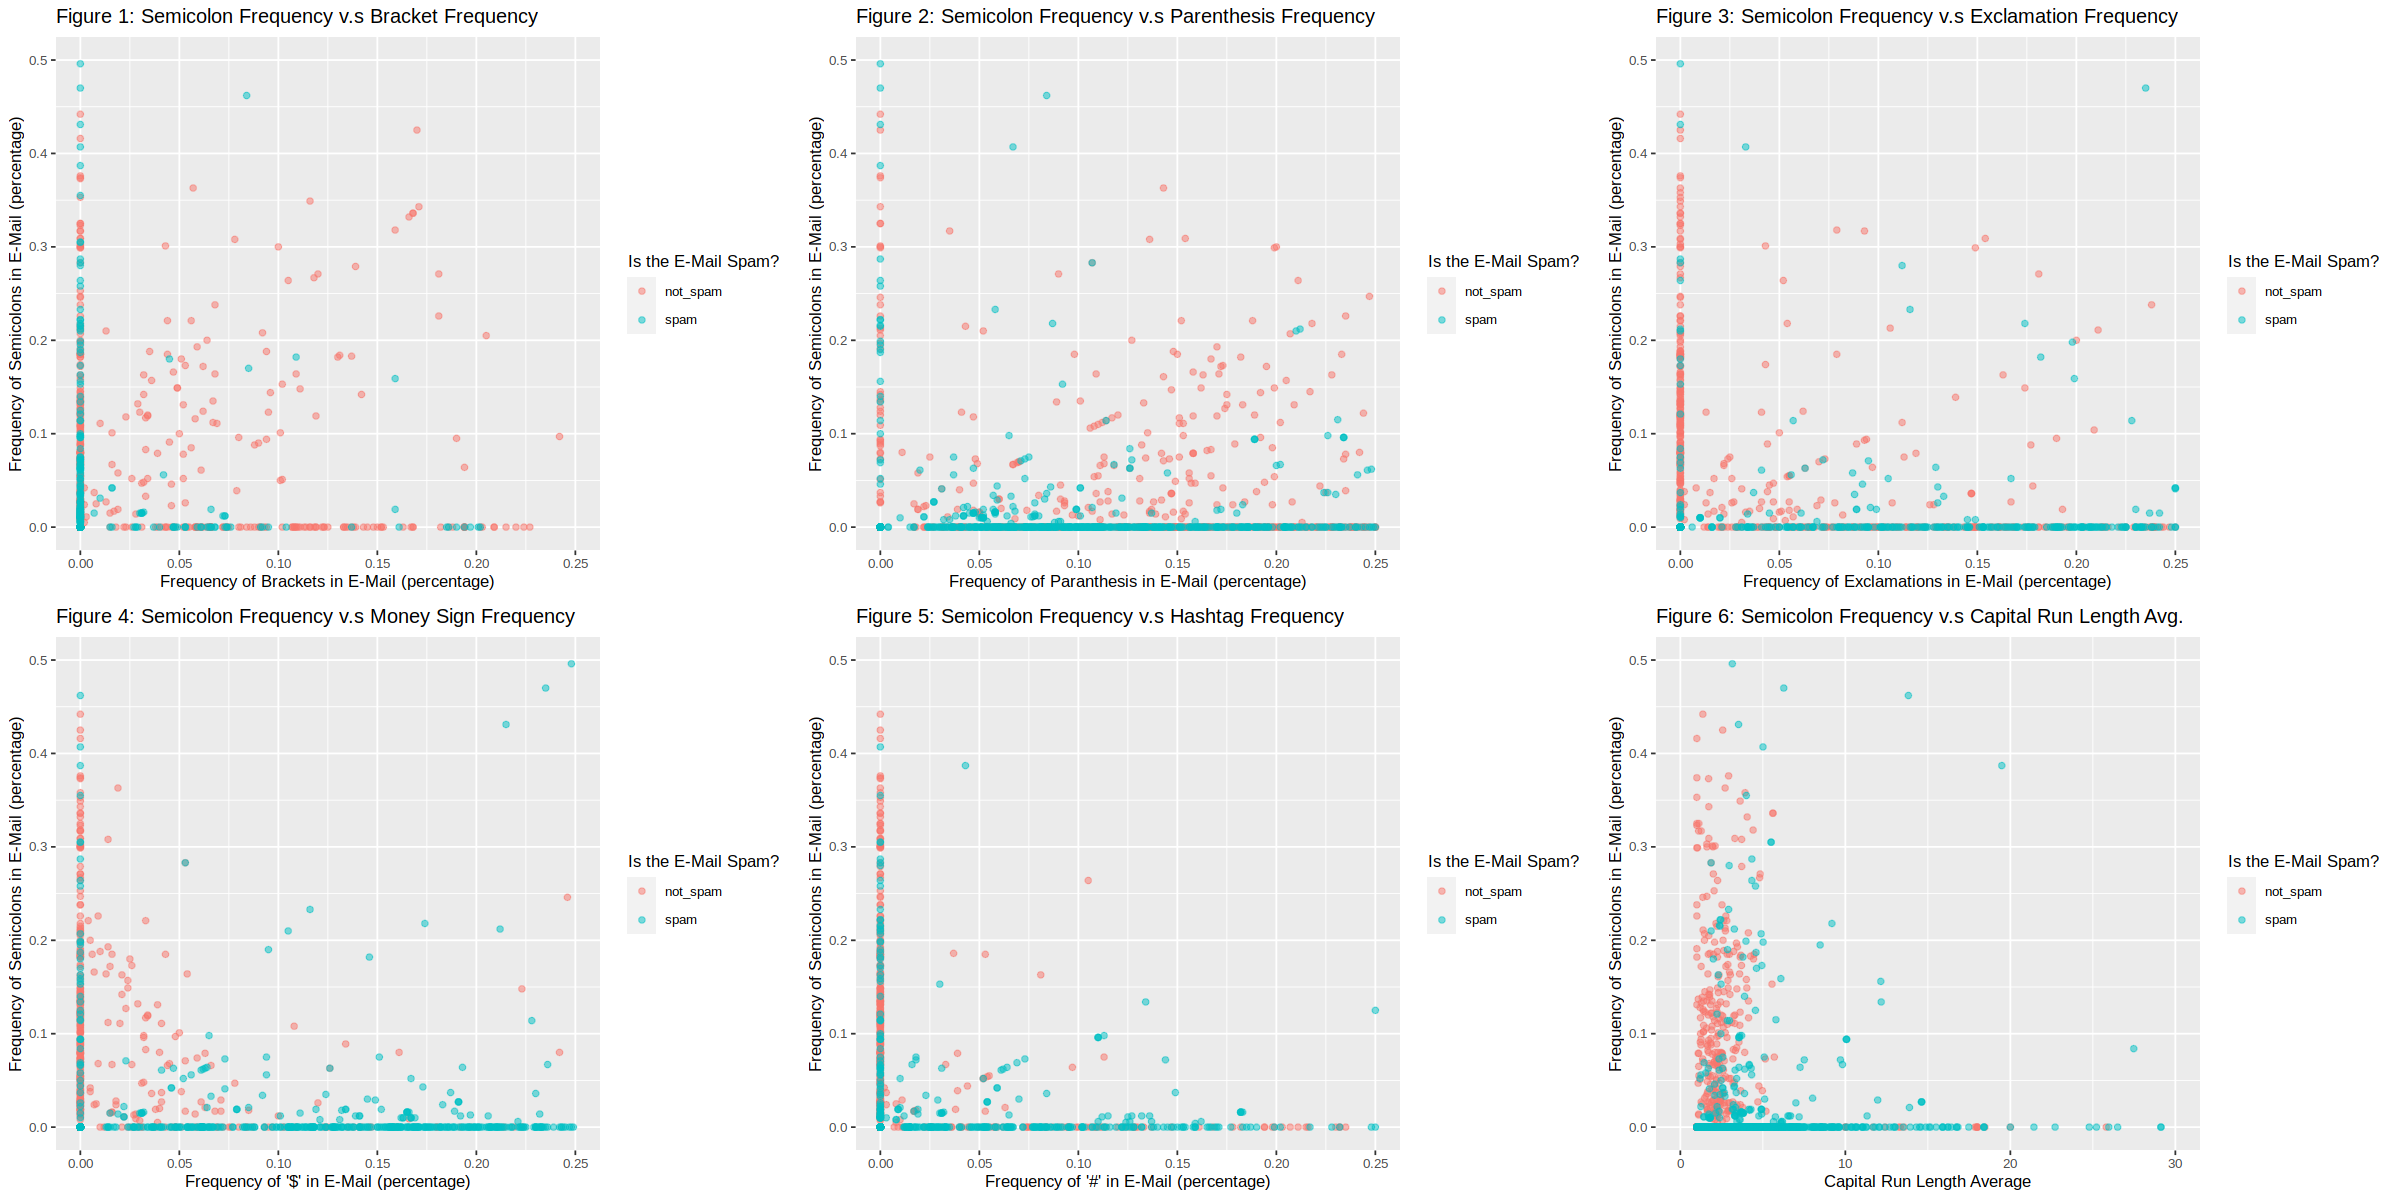

In [73]:
library(repr) # for setting the height and width of the plots 

options(repr.plot.width = 20, repr.plot.height = 10)

spam_plot1 <- spam_training |>
    ggplot(aes(x = char_freq_brack, y = char_freq_semicolon, colour = spam_or_not_spam)) +
    geom_point(alpha = 0.5) +
    labs(x = "Frequency of Brackets in E-Mail (percentage)", y = "Frequency of Semicolons in E-Mail (percentage)", colour = "Is the E-Mail Spam?") +
    xlim(c(0, 0.25)) +
    ylim(c(0, 0.5)) +
    theme(text = element_text(size = 10)) +
    ggtitle("Figure 1: Semicolon Frequency v.s Bracket Frequency")

spam_plot2 <- spam_training |>
    ggplot(aes(x = char_freq_paren, y = char_freq_semicolon, colour = spam_or_not_spam)) +
    geom_point(alpha = 0.5) +
    labs(x = "Frequency of Paranthesis in E-Mail (percentage)", y = "Frequency of Semicolons in E-Mail (percentage)", colour = "Is the E-Mail Spam?") +
    xlim(c(0, 0.25)) +
    ylim(c(0, 0.5)) +
    theme(text = element_text(size = 10)) +
    ggtitle("Figure 2: Semicolon Frequency v.s Parenthesis Frequency")

spam_plot3 <- spam_training |>
    ggplot(aes(x = char_freq_excl, y = char_freq_semicolon, colour = spam_or_not_spam)) +
    geom_point(alpha = 0.5) +
    labs(x = "Frequency of Exclamations in E-Mail (percentage)", y = "Frequency of Semicolons in E-Mail (percentage)", colour = "Is the E-Mail Spam?") +
    xlim(c(0, 0.25)) +
    ylim(c(0, 0.5)) +
    theme(text = element_text(size = 10)) +
    ggtitle("Figure 3: Semicolon Frequency v.s Exclamation Frequency")

spam_plot4 <- spam_training |>
    ggplot(aes(x = char_freq_mon, y = char_freq_semicolon, colour = spam_or_not_spam)) +
    geom_point(alpha = 0.5) +
    labs(x = "Frequency of '$' in E-Mail (percentage)", y = "Frequency of Semicolons in E-Mail (percentage)", colour = "Is the E-Mail Spam?") +
    xlim(c(0, 0.25)) +
    ylim(c(0, 0.5)) +
    theme(text = element_text(size = 10)) +
    ggtitle("Figure 4: Semicolon Frequency v.s Money Sign Frequency")

spam_plot5 <- spam_training |>
    ggplot(aes(x = char_freq_hash, y = char_freq_semicolon, colour = spam_or_not_spam)) +
    geom_point(alpha = 0.5) +
    labs(x = "Frequency of '#' in E-Mail (percentage)", y = "Frequency of Semicolons in E-Mail (percentage)", colour = "Is the E-Mail Spam?") +
    xlim(c(0, 0.25)) +
    ylim(c(0, 0.5)) +
    theme(text = element_text(size = 10)) +
    ggtitle("Figure 5: Semicolon Frequency v.s Hashtag Frequency")

spam_plot6 <- spam_training |>
    ggplot(aes(x = capital_run_length_average, y = char_freq_semicolon, colour = spam_or_not_spam)) +
    geom_point(alpha = 0.5) +
    labs(x = "Capital Run Length Average", y = "Frequency of Semicolons in E-Mail (percentage)", colour = "Is the E-Mail Spam?") +
    xlim(c(0, 30)) +
    ylim(c(0, 0.5)) +
    theme(text = element_text(size = 10)) +
    ggtitle("Figure 6: Semicolon Frequency v.s Capital Run Length Avg.")


suppressWarnings(plot_grid(spam_plot1, spam_plot2, spam_plot3, spam_plot4, spam_plot5, spam_plot6))


## The graphs tells us the relationship between two of the predictor variables, and is coloured by class of spam or not spam
## the importance of this graph lies in the fact that as the frequency of brackets and semicolons goes up, it is more likely for the e-mail to be spam
## this can lead to interesting conclusions as one may suspect the opposite case (excsessive brackets and semicolons leading to spam e-mail)

### How will we conduct our analysis? What variables will we consider?

We will conduct our analysis via KNN classification, as we are considering a binary classification of "spam" or "not spam" E-Mails, which are categorical classifications. We will consider the result of our model through accuracy, and also precision/recall, to determine how our model treated positives and negatives. The raw dataset contained 58 features, but for the purpose of this project we consider 7: frequency of characters such as hard and soft brackets, semicolons, money symbols, exclamation points, and hash signs (**all as percentages**), as well as the average length of uninterrupted capital letters (i.e "AAABSsdA") has a length of 5 uninterrupted capitals. To choose these we took into account articles such as [(Forbes, 2010)]("https://www.forbes.com/sites/firewall/2010/03/17/the-most-common-words-in-spam-email/?sh=5f23e8df7d80"), which consider words that are most frequent in spam e-mails. These words often contain the aforementioned symbols (brackets, exclamations, etc.), and so we believed that it would make for a good classification to use these as our predictors.

Word Count: 152 Words

### How will we visualize our results?

We will visualize our results via multiple plots as shown above, considering all of the different features and colored by the class of "spam" or "not_spam". We can then create background fields of the colours of spam or not spam, to indicate how much of the graph would have been classified as spam and how much would have been classified as not spam, considering an arbitrary unknown observation. For our accuracy we will look to plot the K values versus our accuracy to see which K yields the best accuracy. 

Word Count: 90 Words 

## Expected Outcomes and Significance

### What do we expect to find?

We expect that E-Mails with high frequency of the listed characters and long sequences of uninterrupted capitals will be classified as spam E-Mails, and low frequency and sequences will be classified as "not spam". 

Word Count: 34 Words

### What impact could such findings have?

The findings in this project could aid data scientists to change their pre-existing classifiers for spam E-Mails, as there may be some results that do not align with their hypothesis'.

Word Count: 30 Words

### What future questions could this lead to?

This project could lead to questions about how E-Mails should/should not be classified as spam; if high frequency characters do **not** lead to spam E-Mail, then data scientists may focus on low frequency characters, and vice versa. 

Word Count: 38 Words

## Conducting Our Analysis (Method & Results)

### Creating the Recipe, Tuning Model, and a measure of Model Results using KNN

In [74]:
set.seed(4321)

spam_vfold <- vfold_cv(spam_training, v = 5, strata = spam_or_not_spam)

spam_recipe <- recipe(spam_or_not_spam ~., data = spam_training) |>
    step_center(all_predictors()) |>
    step_scale(all_predictors())

knn_tune <- nearest_neighbor(weight_func = 'rectangular', neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification") 

knn_results <- workflow() |>
    add_recipe(spam_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = spam_vfold, grid = 10) |>
    collect_metrics()

accuracies <- knn_results |>
    filter(.metric == 'accuracy')


#### Table 7: First Three Rows of Metric Results of Our Classification Model with 14 Different K Values

In [75]:
head(knn_results, n = 3)

neighbors .metric  .estimator mean      n std_err     .config              
1 2         accuracy binary     0.8274753 5 0.004050127 Preprocessor1_Model01
2 2         roc_auc  binary     0.8597166 5 0.004378088 Preprocessor1_Model01
3 4         accuracy binary     0.8452454 5 0.004959279 Preprocessor1_Model02

#### Table 8: Last Three Rows of Metric Results of Our Classification Model with 14 Different K Values

In [76]:
tail(knn_results, n = 3)

neighbors .metric  .estimator mean      n std_err     .config              
1 13        roc_auc  binary     0.8955709 5 0.004900427 Preprocessor1_Model09
2 14        accuracy binary     0.8426848 5 0.004730231 Preprocessor1_Model10
3 14        roc_auc  binary     0.8960509 5 0.005276679 Preprocessor1_Model10

#### Table 9: Demonstrating All Model Accuracy Achieved with Each K Value

In [77]:
accuracies

neighbors .metric  .estimator mean      n std_err     .config              
1   2        accuracy binary     0.8274753 5 0.004050127 Preprocessor1_Model01
2   4        accuracy binary     0.8452454 5 0.004959279 Preprocessor1_Model02
3   5        accuracy binary     0.8463264 5 0.005167634 Preprocessor1_Model03
4   7        accuracy binary     0.8481321 5 0.004990750 Preprocessor1_Model04
5   8        accuracy binary     0.8481321 5 0.004990750 Preprocessor1_Model05
6   9        accuracy binary     0.8430518 5 0.003103136 Preprocessor1_Model06
7  11        accuracy binary     0.8455834 5 0.004525259 Preprocessor1_Model07
8  12        accuracy binary     0.8455834 5 0.004525259 Preprocessor1_Model08
9  13        accuracy binary     0.8423232 5 0.004459979 Preprocessor1_Model09
10 14        accuracy binary     0.8426848 5 0.004730231 Preprocessor1_Model10

### Plotting Accuracy Versus K Value to Yield the Best K for Upcoming Analysis

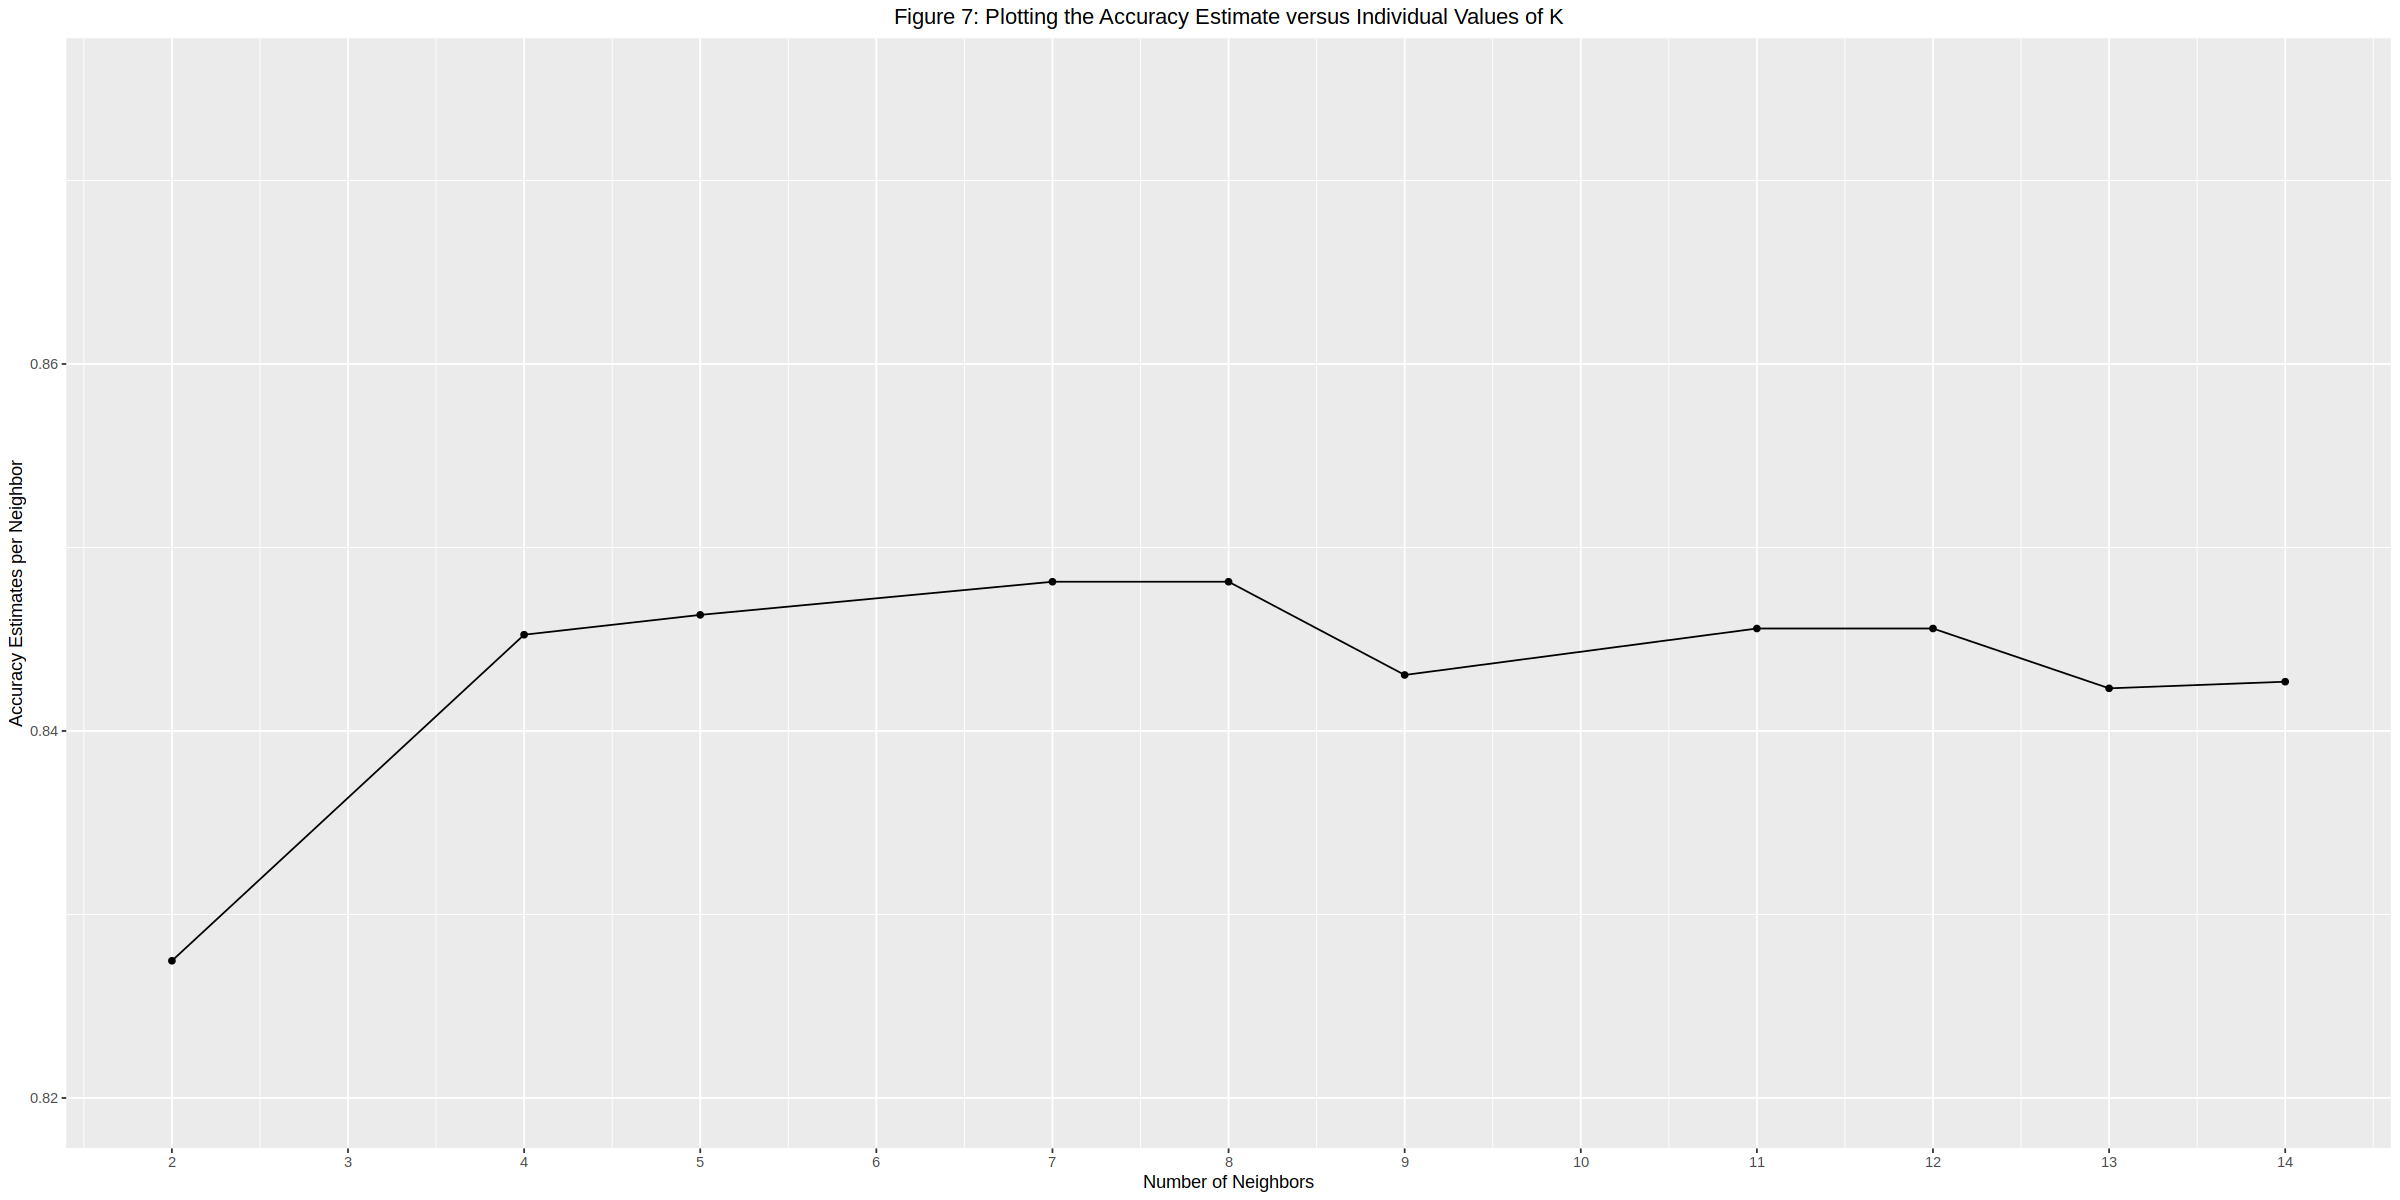

In [78]:
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = 'Number of Neighbors', y = 'Accuracy Estimates per Neighbor') +
    scale_x_continuous(breaks = seq(0, 14, by = 1)) +
    scale_y_continuous(limits = c(0.82, 0.875)) +
    ggtitle("Figure 7: Plotting the Accuracy Estimate versus Individual Values of K") +
    theme(plot.title = element_text(hjust = 0.5))

accuracy_vs_k

### Creating KNN Model with New K Value, and Fitting the Model 

In [79]:
knn_spec <- nearest_neighbor(weight_func = 'rectangular', neighbors = 7) |>
    set_engine("kknn") |>
    set_mode("classification") 

spam_fit <- workflow() |>
    add_recipe(spam_recipe) |>
    add_model(knn_spec) |>
    fit(data = spam_training)

spam_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_center()
• step_scale()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(7,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.148967
Best kernel: rectangular
Best k: 7

### Determining Model Accuracy and Implementing a Confusion Matrix

#### Table 10: Determining a Measure of Accuracy for Our Classification Model

In [80]:
spam_test_predictions <- predict(spam_fit, spam_training) |>
    bind_cols(spam_training)

spam_prediction_accuracy <- spam_test_predictions |>
    metrics(truth = spam_or_not_spam, estimate = .pred_class) |>
    filter(.metric == "accuracy") |>
    select(-.estimator)

spam_prediction_accuracy



.metric  .estimate
1 accuracy 0.8822037

#### Table 11: Creating a Confusion Matrix for Our Model to Assess Precision and Recall

In [81]:
spam_matrix <- spam_test_predictions |>
    conf_mat(truth = spam_or_not_spam, estimate = .pred_class)

spam_matrix

          Truth
Prediction not_spam spam
  not_spam     1563  216
  spam          109  871

### Implementing Our Model with a New Observation!

In [82]:
new_spam <- tibble(char_freq_semicolon = c(0.001), char_freq_paren = c(0.001), char_freq_brack = c(0.001), 
                  char_freq_excl = c(1), char_freq_mon = c(0.001), char_freq_hash = c(0.001), capital_run_length_average = c(20))

new_pred <- predict(spam_fit, new_spam)
new_pred

.pred_class
1 spam

## Discussion and Evaluation of Our Model

### Total Word Count: 2000 Words 

 ## Works Cited

- [UCI Machine Learning Repo, Spambase Dataset, 1999]("https://archive.ics.uci.edu/dataset/94/spambase")
- [Forbes Article on Frequent Words in Spam Emails, 2010]("https://www.forbes.com/sites/firewall/2010/03/17/the-most-common-words-in-spam-email/?sh=5f23e8df7d80")
- [Virus Basics from CISA, 2023]("https://www.cisa.gov/news-events/news/virus-basics")